In [3]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using LinearAlgebra
using Printf
using ForwardDiff
using JuMP
using COSMO
using ECOS
using Random; 

  Activating environment at `~/SSD/Code/TinyMPC/julia/altro_rocket/Project.toml`


LoadError: ArgumentError: Package JuMP not found in current path:
- Run `import Pkg; Pkg.add("JuMP")` to install the JuMP package.


In [ ]:
# -------------------THIS IS ALL ALTRO-------------------------------
# This enables goal equality constraints, state and input ineq constraints.

function stage_cost(p::NamedTuple,x,u,k)
    dx = x - p.Xref[k]
    du = u - p.Uref[k]
    return 0.5*dx'*p.Q*dx + 0.5*du'*p.R*du
end
function term_cost(p::NamedTuple,x)
    dx = x - p.Xref[p.N]
    return 0.5*dx'*p.Qf*dx
end
function stage_cost_expansion(p::NamedTuple,k)
    dx = - p.Xref[k]
    du = - p.Uref[k]
    return p.Q, p.Q*dx, p.R, p.R*du  # Hessian and gradient
end
function term_cost_expansion(p::NamedTuple)
    dx = - p.Xref[p.N]
    return p.Qf, p.Qf*dx
end
function conic_cost_expansion(p::NamedTuple, u, λc, ρ, k)
    λhat = λc # already updated
    ∇c = cone_u_jac(p, u)
    G = -∇c'*∇projection(λhat)*projection(λhat)
    # H = ∇c'*∇projection(λhat)'*∇projection(λhat)*∇c/ρ
    H = ∇c'*(∇projection(λhat)'*∇projection(λhat) + ∇²projection(λhat, projection(λhat)))*∇c*ρ
    return (G - H*u), H
end
function backward_pass!(params,X,U,P,p,d,K,reg,μ,μx,ρ,λ,λc)
    """iLQR backward pass with AL. This !function update its parameters
    """
    N = params.N
    ΔJ = 0.0    # expected cost reduction

    # terminal cost expansion
    P[N], p[N] = term_cost_expansion(params) 
    
    if (params.ncx > 0)
        # # add AL terms for the state constraint at the final time step
        hxv = ineq_con_x(params,X[N])  # h(x) violation  
        mask = eval_mask(μx[N],hxv)
        ∇hx = ineq_con_x_jac(params,X[N])
        # add these into the cost-to-go p and P
        p[N]  += ∇hx'*(μx[N] - ρ*(mask * [params.x_max;-params.x_min]))  # multiplier term (1st)
        P[N]  += ρ*∇hx'*mask*∇hx                # penalty term (2nd)
        ΔJ += 
    end
    
    if (params.ncg > 0)
        # add AL terms for goal constraint 
        ∇hx = diagm(ones(params.nx))
        # add these into the CTG p and P (equality active)
        p[N]  += ∇hx'*(λ - 0*ρ*params.Xref[N])   
        P[N]  += ρ*∇hx'∇hx
    end
    
    # iterate from N-1 to 1 backwards
    for k = (N-1):(-1):1
        # dynamics jacobians (linearization about previous iterate)
        A = ForwardDiff.jacobian(_x -> discrete_dynamics(params,_x,U[k],k),X[k])
        B = ForwardDiff.jacobian(_u -> discrete_dynamics(params,X[k],_u,k),U[k])

        Sxx,Sx,Suu,Su = stage_cost_expansion(params,k)
        
        # one-step cost expansion: Q, Q*dx, R, R*du
        Sx += A' * (P[k+1]*f + p[k+1]) 
        Su += B' * (P[k+1]*f + p[k+1]) 
        Sxx += A'*(P[k+1])*A
        Suu += B'*(P[k+1] + reg*I)*B                                     
        Sux = B'*(P[k+1])*A  
        if (params.ncu > 0)
            # control constraints
            huv = ineq_con_u(params,U[k])  # calculate h(u) constraint
            mask = eval_mask(μ[k],huv)  # choose active
            ∇hu = ineq_con_u_jac(params,U[k])
            μ[k] .= μ[k] - ρ*(mask * [params.u_max;-params.u_min])
            Su  += ∇hu'*μ[k] # add to cost
            Suu += ρ*∇hu'*mask*∇hu
        end
        if (params.ncx > 0)
            # state constraints
            hxv = ineq_con_x(params,X[k])
            mask = eval_mask(μx[k],hxv)
            ∇hx = ineq_con_x_jac(params,X[k])
            μx[k] .= μx[k] - 0*ρ*(mask * [params.x_max;-params.x_min])
            Sx  += ∇hx'*μx[k]
            Sxx += ρ*∇hx'*mask*∇hx
        end
        if (params.ncu_cone > 0)
            # conic constraints
            Qu, Quu = conic_cost_expansion(params, U[k], λc[k], ρ*cone_scale, k)
            # display(Quu)
            Su += Qu
            Suu += Quu
        end
        
        # Calculate Gains
        # for i = 1:10
        #     if isposdef(Suu) == 0
        #         Suu += reg*I
        #     end
        # end
        F = cholesky(Symmetric(Suu))
        d[k] = Suu\Su
        K[k] = Suu\Sux

        # Cost-to-go Recurrence (PSD stabilizing version, last term)
        P[k] = Sxx + K[k]'*Suu*K[k] - 2*K[k]'*Sux
        p[k] = Sx + K[k]'*Suu*d[k] - K[k]'*Su - Sux'*d[k]
        ΔJ += Su'*d[k]
    end

    return ΔJ  # but also change params
end
function forward_pass!(params,X,U,K,d,ΔJ,Xn,Un,μ,μx,ρ,λ; 
                        max_linesearch_iters = 20)
    """iLQR forward pass and line-search
    This !function update its parameters
    """
    N = params.N
        # Forward Rollout
        for k = 1:(N-1)
            Un[k] = - d[k] - K[k]*Xn[k] 
            Xn[k+1] = discrete_dynamics(params,Xn[k],Un[k],k)
        end
    X .= Xn
    U .= Un
    return 0, 0
end
function eval_mask(μv,huv)  
    # Extract active inequality constraints
    # active set mask
    mask = Diagonal(zeros(length(huv)))
    for i = 1:length(huv)
        mask[i,i] = (μv[i] > 0 || huv[i] > 0)
    end
    mask
end
function mpc(params,X,U,P,p,K,d,Xn,Un;atol=1e-3,max_iters = 250,verbose = true,ρ=1,ρmax=1e8,ϕ=10)

    # first check the sizes of everything
    # @assert length(X) == params.N
    # @assert length(U) == params.N-1
    # @assert length(X[1]) == params.nx
    # @assert length(U[1]) == params.nu

    # initial rollout
    N = params.N
    for i = 1:N-1
        X[i+1] = discrete_dynamics(params,X[i],U[i],i)
    end

    reg_min = 0*1e-8
    reg = reg_min

    μ = params.μ   # input constraints
    μx = params.μx    # state constraints
    λ = params.λ    # goal constraint
    λc = params.λc   # goal constraint
    
    # Inner loop to solve unconstrained problem (Riccati)
    for iter = 1:max_iters        
        J = 0.0
        ΔJ = 0.0
        α = 1.0
        for i = 1:1
            ΔJ = backward_pass!(params,X,U,P,p,d,K,reg,μ,μx,ρ,λ,λc)
            J, α = forward_pass!(params,X,U,K,d,ΔJ,Xn,Un,μ,μx,ρ,λ)
        end

        if verbose
            if rem(iter-1,10)==0
                @printf "iter     J           ΔJ        |d|         α        reg         ρ\n"
                @printf "---------------------------------------------------------------------\n"
            end
            @printf("%3d   %10.3e  %9.2e  %9.2e  %6.4f   %9.2e   %9.2e\n",
              iter, J, ΔJ, 0, α, reg, ρ)
        end
        # update multipliers and check constraint violation, max of all
        convio = 0.0  
        
        if (params.ncu > 0)
            # control constraints (inequality)
            for k = 1:N-1
                huv = ineq_con_u(params,U[k])
                mask = eval_mask(μ[k],huv)
                # update dual?
                convio = max(convio,norm(huv + abs.(huv),Inf))
                # μ[k] .= max.(0,μ[k] - ρ*(mask * [params.u_max;-params.u_min]))
            end
        end
        if (params.ncx > 0)
            # state constraints (inequality)
            for k = 1:N
                hxv = ineq_con_x(params,X[k])
                mask = eval_mask(μx[k],hxv)
                # update dual
                convio = max(convio,norm(hxv + abs.(hxv),Inf))
                # @show μx[k] .= max.(0,μx[k] - ρ*(mask * [params.x_max;-params.x_min]))                
            end
        end
        if (params.ncu_cone > 0)
            # conic constraints 
            if verbose
                print("update cone\n")
            end            
            for k = 1:N-1
                # update dual
                Uc = cone_u(params, U[k])
                huc = norm(Uc[1:2]) - Uc[3]
                convio = max(convio, norm(huc + abs.(huc),Inf))
                λc[k] = projection(λc[k] - Uc*cone_scale*ρ)
                # display(λc[k])
            end
        end
        if (params.ncg > 0)
            # goal constraint (equality)
            hxv = X[N] - params.Xref[N]
            # λ .-= ρ*params.Xref[N]
            convio = max(convio, norm(hxv,Inf))
        end
        
        ρ *= ϕ  # update penalty
        
        if verbose
            @show convio
        end
        if convio < atol  # if terminal condition with contraint violation
            # print("Our solver says SUCCESS\n") # @info "success!"
            return U[1]
        end
        if ρ > ρmax
            print("Our solver reachs MAX PENALTY\n")
            return U[1]
        end
    end
    print("Our solver says INFEASIBLE and MAX ITER\n")
    return U[1]
end
#----------------------ALTRO DONE --------------------------

mpc (generic function with 1 method)

In [ ]:
# =============================
# Example problem formulation and solve
# =============================

# ---------------------THIS IS WHAT YOU NEED TO INPUT--------
A = [1.0 0.0 0.0 0.05 0.0 0.0; 
    0.0 1.0 0.0 0.0 0.05 0.0; 
    0.0 0.0 1.0 0.0 0.0 0.05; 
    0.0 0.0 0.0 1.0 0.0 0.0; 
    0.0 0.0 0.0 0.0 1.0 0.0; 
    0.0 0.0 0.0 0.0 0.0 1.0]
B = [0.000125 0.0 0.0; 
    0.0 0.000125 0.0;
    0.0 0.0 0.000125; 
    0.005 0.0 0.0; 
    0.0 0.005 0.0; 
    0.0 0.0 0.005]
f = [0.0, 0.0, -0.0122625, 0.0, 0.0, -0.4905]
function discrete_dynamics(p::NamedTuple,x,u,k)
    A = [1.0 0.0 0.0 0.05 0.0 0.0; 
        0.0 1.0 0.0 0.0 0.05 0.0; 
        0.0 0.0 1.0 0.0 0.0 0.05; 
        0.0 0.0 0.0 1.0 0.0 0.0; 
        0.0 0.0 0.0 0.0 1.0 0.0; 
        0.0 0.0 0.0 0.0 0.0 1.0]
    B = [0.000125 0.0 0.0; 
        0.0 0.000125 0.0;
        0.0 0.0 0.000125; 
        0.005 0.0 0.0; 
        0.0 0.005 0.0; 
        0.0 0.0 0.005]
    f = [0.0, 0.0, -0.0122625, 0.0, 0.0, -0.4905]
    return A*x + B*u + f
end
function ineq_con_x(p,x)
    [x-p.x_max;-x + p.x_min]
end
function ineq_con_u(p,u)
    [u-p.u_max;-u + p.u_min]
end
function cone_u(p, u)
    [p.A_cone*u;p.c_cone'*u]
end
function cone_u_jac(p, u)
    J = zeros(p.nu, p.nu)
    J[1:end-1,1:end] .= p.A_cone
    J[end,1:end] .= p.c_cone
    return J
end
function ineq_con_u_jac(params,u)
    ForwardDiff.jacobian(_u -> ineq_con_u(params,_u), u)
end
function ineq_con_x_jac(p,x)
    ForwardDiff.jacobian(_x -> ineq_con_x(p,_x),x)
end
function projection(x)
    # assumes x is stacked [v; s] such that ||v||₂ ≤ s
    n = length(x)
    v = view(x, 1:n-1)
    s = x[end]
    a = norm(v)
    if a <= -s          # below the cone
        return zero(x) 
    elseif a <= s       # in the cone
        return x
    elseif a >= abs(s)  # outside the cone
        return 0.5 * (1 + s/a) * [v; a]
    else
        throw(ErrorException("Invalid second-order cone projection"))
    end
end
function ∇projection(x)
    n = length(x)
    J = zeros(eltype(x),n,n)
    s = x[end]
    v = view(x,1:n-1)
    a = norm(v)
    if a <= -s
        return J  # zeros
    elseif a <= s
        J .= I(n)  
        return J  # identity
    elseif a >= abs(s)
        c = 0.5 * (1 + s/a)

        # dvdv ok!
        for i = 1:n-1, j = 1:n-1
            J[i,j] = -0.5*s/a^3 * v[i] * v[j]
            if i == j
                J[i,j] += c
            end
        end

        # dvds ok!
        for i = 1:n-1
            J[i,n] = 0.5 * v[i] / a
        end

        # dsdv ok!
        for i = 1:n-1
            J[n,i] = ((-0.5*s/a^2) + c/a) * v[i]
        end
        J[n,n] = 0.5  # ok
        return J
    else
        error("Invalid second-order cone projection.")
    end
    return J
end
function ∇projection(x) 
    n = length(x)
    v = view(x, 1:n-1)
    s = x[end]
    a = norm(v)
    J = zeros(n, n)
    if a <= -s                               # below cone
        J .*= 0
    elseif a <= s                            # in cone
        J .*= 0
        for i = 1:n
            J[i,i] = 1.0
        end
    elseif a >= abs(s)                       # outside cone
        # scalar
        c = 0.5 * (1 + s/a)   

        # dvdv = dbdv * v' + c * oneunit(SMatrix{n-1,n-1,T})
        for i = 1:n-1, j = 1:n-1
            J[i,j] = -0.5*s/a^3 * v[i] * v[j]
            if i == j
                J[i,j] += c
            end
        end

        # dvds
        for i = 1:n-1
            J[i,n] = 0.5 * v[i] / a
        end

        # ds
        for i = 1:n-1
            J[n,i] = ((-0.5*s/a^2) + c/a) * v[i]
        end
        J[n,n] = 0.5 
    else
        throw(ErrorException("Invalid second-order cone projection"))
    end
    return J
end
function ∇²projection(x, b)
    # x is lamda_bar, b is projection(lambda_bar)
    n = length(x)
    hess = zeros(eltype(x),n,n)
    v = view(x, 1:n-1)
    bv = view(b, 1:n-1)

    # @assert size(hess) == (n+1,n+1)
    s = x[end]
    bs = b[end]
    a =  norm(v)
    vbv = dot(v,bv)

    if a <= -s
        return hess .= 0
    elseif a <= s
        return hess .= 0
    elseif a > abs(s)
        # Original equations from chain rule
        # dvdv = -s/norm(v)^2/norm(v)*(I - (v*v')/(v'v))*bv*v' + 
        #     s/norm(v)*((v*(v'bv))/(v'v)^2 * 2v' - (I*(v'bv) + v*bv')/(v'v)) + 
        #     bs/norm(v)*(I - (v*v')/(v'v))
        # dvds = 1/norm(v)*(I - (v*v')/(v'v))*bv;
        # # display(dvds)
        # # display(dvdv)
        # hess[1:n-1,1:n-1] .= dvdv*0.5
        # hess[1:n-1,n] .= dvds*0.5
        # hess[n:n,1:n-1] .= 0.5*dvds'
        # hess[n,n] = 0
        # return hess

        # The following is just an unrolled version of the above
        n = n - 1
        dvdv = view(hess, 1:n, 1:n)
        dvds = view(hess, 1:n, n+1)
        dsdv = view(hess, n+1, 1:n)
        @inbounds for i = 1:n
            hi = 0
            @inbounds for j = 1:n
                Hij = -v[i]*v[j] / a^2
                if i == j
                    Hij += 1
                end
                hi += Hij * bv[j]
            end
            dvds[i] = hi / 2a
            dsdv[i] = dvds[i]
            @inbounds for j = 1:i
                vij = v[i] * v[j]
                H1 = hi * v[j] * (-s/a^3)
                H2 = vij * (2*vbv) / a^4 - v[i] * bv[j] / a^2
                H3 = -vij / a^2
                if i == j
                    H2 -= vbv / a^2
                    H3 += 1
                end
                H2 *= s/a
                H3 *= bs/a
                dvdv[i,j] = (H1 + H2 + H3) / 2
                dvdv[j,i] = dvdv[i,j]
            end
        end
        hess[end,end] = 0
        return hess
    else
        throw(ErrorException("Invalid second-order cone projection"))
    end
end

∇²projection (generic function with 1 method)

iter     J           ΔJ        |d|         α        reg         ρ
---------------------------------------------------------------------
  1    0.000e+00   3.04e+06   0.00e+00  0.0000    0.00e+00    1.00e+02
convio = 5.49967797973767
  2    0.000e+00   3.38e+06   0.00e+00  0.0000    0.00e+00    1.00e+03
convio = 5.527682734136084
  3    0.000e+00   3.30e+06   0.00e+00  0.0000    0.00e+00    1.00e+04
convio = 1.5618078043024464
  4    0.000e+00   3.30e+06   0.00e+00  0.0000    0.00e+00    1.00e+05
convio = 1.2173168934150915
  5    0.000e+00   3.58e+06   0.00e+00  0.0000    0.00e+00    1.00e+06
convio = 0.019579635134449325
  6    0.000e+00   5.87e+06   0.00e+00  0.0000    0.00e+00    1.00e+07
convio = 1.2098559782363996
  7    0.000e+00   2.79e+07   0.00e+00  0.0000    0.00e+00    1.00e+08
convio = 0.0005714847241545945
Our solver reachs MAX PENALTY


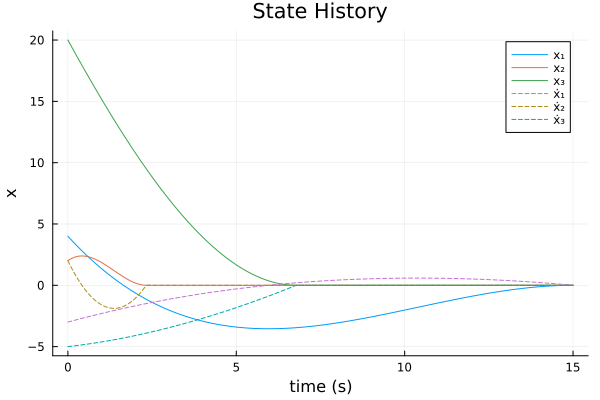

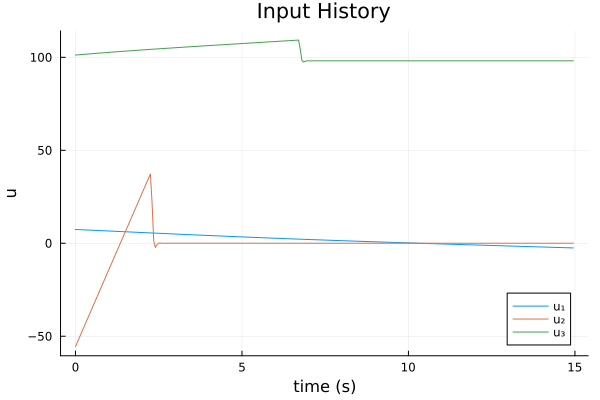

In [ ]:
# Let's solve
# include("mpc_JuMP.jl")

nx = 6
nu = 3
N = 301
dt = 0.05
t_vec = dt*(0:N-1)
x0 = [4, 2, 20, -3, 2, -5.0]
xg = [0,0,0,0,0,0.0]
Xref = [deepcopy(xg) for i = 1:N]
Uref = [zeros(nu) for i = 1:N-1]

Q = 1e-1*I(nx)
R = 1e-0*I(nu)
Qf = 1000*I(nx)

# ground_level = 0.0
gravity = [0; 0; -9.81]
mass = 10.0
# ωPlanet = [0.0; 0.0; 0.0]
perWeightMax = 2.0
θ_thrust_max = 5.0  # deg
# θ_glideslope = 60.0 # deg
# glide_recover_k = 8

A_cone = [1 0 0; 0 1 0]
c_cone = [0.0, 0.0, tand(θ_thrust_max)]
u_bnd = mass * abs(gravity[3]) * perWeightMax
u_min = -10*ones(nu)
u_max =  102*ones(nu)

# state is x y v θ
x_min = [-5,-5,0,-10,-10,-10.0]
x_max = [5,5,20,10,10,10.0]

ncx = 2*nx*1
ncu = 2*nu*0
ncg = 1
ncu_cone = nu*0; 
cone_scale = 1e-2  # very fragile for each problem

μ = [zeros(ncu) for i = 1:N-1]   # input constraints
μx = [zeros(ncx) for i = 1:N]    # state constraints
λ = zeros(nx)    # goal constraint
λc = [zeros(ncu_cone) for i = 1:N-1]   # goal constraint

params = (
    nx = nx,
    nu = nu,
    ncx = ncx,
    ncu = ncu,
    ncg = ncg,
    ncu_cone = ncu_cone,
    μ = μ, μx = μx, λ = λ, λc = λc,
    A_cone = A_cone,
    c_cone = c_cone,A
    N = N,
    Q = Q,
    R = R,
    Qf = Qf,
    u_min = u_min,
    u_max = u_max,
    x_min = x_min,
    x_max = x_max,
    Xref = Xref,A
    Uref = Uref,
    dt = dt,
    mc = 1.0,
    mp = 0.2,
    l = 0.5,
    g = 9.81,
);

# previous iterate
X = [deepcopy(x0) for i = 1:N]
U = [ones(nu) for k = 1:N-1]
# X = Xref*1
# U = Uref*1
# new iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
p = [zeros(nx) for i = 1:N]      # cost to go linear term
d = [zeros(nu) for i = 1:N-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:N-1] # feedback gain

include("mpc_JuMP.jl")
optimizers = (
    JuMP.optimizer_with_attributes(COSMO.Optimizer,
        "verbose"=>false,
        "eps_abs"=>1e-4,
        "eps_rel"=>1e-4,
        "rho"=>1e-2,
        "scaling"=>0,
        "alpha"=>1.0),
    JuMP.optimizer_with_attributes(ECOS.Optimizer, 
        "verbose"=>false,
        "feastol"=>1e-4,
        "abstol"=>1e-4,
        "reltol"=>1e-4)) 
# trajopt_JuMP1(optimizers[1], params, Xn, Un, A, B, f; warm_start=false)
u_ = mpc(params,X,U,P,p,K,d,Xn,Un; atol=1e-4, max_iters = 20, verbose = true, ρ = 1e2, ρmax = 1e8, ϕ = 10.0);

function mat_from_vec(X::Vector{Vector{Float64}})::Matrix
    # convert a vector of vectors to a matrix 
    Xm = hcat(X...)
    return Xm 
end
Xsim_m = mat_from_vec(Xn)
Usim_m = mat_from_vec(Un)
using Plots
display(plot(t_vec,Xsim_m',label = ["x₁" "x₂" "x₃" "ẋ₁" "ẋ₂" "ẋ₃"],linestyle=[:solid :solid :solid :dash :dash :dash],
             title = "State History",
             xlabel = "time (s)", ylabel = "x"))
display(plot(t_vec[1:end-1],Usim_m',label = ["u₁" "u₂" "u₃"],
             title = "Input History",
             xlabel = "time (s)", ylabel = "u"))

LoadError: UndefVarError: I not defined

In [ ]:
# Enable warm-starting
function trajopt_JuMP1(optimizer, params, X, U, A, B, f; warm_start=true)
  Nh = params.N
  nx = params.nx
  nu = params.nu
  α_max = params.c_cone[3]
  NN = Nh*nx + (Nh-1)*nu
  x0 .= X[1]
  
  inds = reshape(1:(nx+nu)*Nh,nx+nu,Nh)  
  xinds = [z[1:nx] for z in eachcol(inds)]
  uinds = [z[nx+1:end] for z in eachcol(inds)][1:Nh-1]    
  
  model = Model(optimizer)
  
  @variable(model, z[1:NN])  # z is all decision variables (X U)
  if warm_start
      z_ws = zeros(NN,1)
      for j = 1:Nh-1
          z_ws[xinds[j]] .= X[j]
          z_ws[uinds[j]] .= U[j]
      end
      z_ws[xinds[Nh]] .= X[Nh]
      set_start_value.(z, z_ws)
  end
  
  P = zeros(NN, NN)
  q = zeros(NN, 1) 
  # Cost function   
  for j = 1:Nh-1
      P[(j-1)*(nx+nu).+(1:nx),(j-1)*(nx+nu).+(1:nx)], q[(j-1)*(nx+nu).+(1:nx)], 
      P[(j-1)*(nx+nu)+nx.+(1:nu),(j-1)*(nx+nu)+nx.+(1:nu)], q[(j-1)*(nx+nu)+nx.+(1:nu)] = stage_cost_expansion(params, j)
  end    
  P[end-nx+1:end,end-nx+1:end], q[end-nx+1:end] = term_cost_expansion(params)
  @objective(model, Min, 0.5*dot(z,P,z) + dot(q,z))

  # Dynamics Constraints
  for k = 1:Nh-1
      @constraint(model, A*z[xinds[k]] .+ B*z[uinds[k]] .+ f .== z[xinds[k+1]])
  end
  
  # Initial condition 
  @constraint(model, z[xinds[1]] .== x0)
  
#   Thrust angle constraint
  if params.ncu_cone > 0 
    for k = 1:Nh-1
        u1,u2,u3 = z[uinds[k]]
        @constraint(model, [α_max * u3, u1, u2] in JuMP.SecondOrderCone())
    end
  end
  
  # State Constraints
  if params.ncx > 0 
    for k = 1:Nh-1
      @constraint(model, z[xinds[k]] .<= params.x_max)
      @constraint(model, z[xinds[k]] .>= params.x_min)
    end  
  end

  # State Constraints
  if params.ncu > 0 
    for k = 1:Nh-1
      @constraint(model, z[uinds[k]] .<= params.u_max)
      @constraint(model, z[uinds[k]] .>= params.u_min)
    end  
  end

  # Goal constraint
  if params.ncg > 0 
      @constraint(model, z[xinds[N]] .== zeros(nx))
  end    

  optimize!(model)   
  termination_status(model) == INFEASIBLE && print("Other solver says INFEASIBLE\n")
  for j = 1:Nh-1
      X[j] .= value.(z[xinds[j]]) 
      U[j] .= value.(z[uinds[j]]) 
  end    
  X[Nh] .= value.(z[xinds[Nh]])
  # display(MOI.get(model, MOI.SolveTimeSec()))
  return X
end

trajopt_JuMP1 (generic function with 1 method)

In [ ]:
@show params.λ'*X[N]
X[N]
# params.μx
convio = 0.0
if params.ncx > 0
  for k = 1:N
    hxv = ineq_con_x(params,X[k])
    mask = eval_mask(μx[k],hxv)
    # update dual
    convio = max(convio,norm(hxv + abs.(hxv),Inf)) 
    @show params.μx[k]'*hxv         
  end
end

(params.λ)' * X[N] = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv = 0.0
(params.μx[k])' * hxv =

For TrajOpt, it needs more tricks to get better results:
- Hessian of the projection => better approximation (done)
- Scaling between conic constraints and other ones (1/rho, Zac did not buy it)
- Solution polishing?

Maybe, we don't care about TrajOpt problem, except from a good initial guess, there is nothing we can tune to get better performance. How about reset mpc?

In [ ]:
# Check conic violation
convio = 0.0
for k = 1:30
    Uc = cone_u(params, Un[k])
    huc = norm(Uc[1:2]) - Uc[3]
    convio = norm(huc + abs.(huc),Inf)
    display(huc) # should <= 0
end
Xref .= Xn;
Uref .= Un;

0.7607807288640416

0.6996756236806245

0.6386095029159282

0.5775858822047848

0.5166082219074664

0.45567992747159103

0.394804349794482

0.3339847855859652

0.2732244777315511

0.2125266156559853

0.1518943356871354

0.0913307214201442

0.030838804081929183

-0.029578437104152755

-0.08991807455337941

-0.1501772319545367

-0.2103530839046428

-0.2704428555435143

-0.33044382218819734

-0.390353308967331

-0.4501686904553761

-0.5098873903068029

-0.5695068808902413

-0.629024682922589

-0.6884383651030728

-0.7477455437473655

-0.8069438824216633

-0.8660310915768132

-0.9250049281824495

-0.9838631953612058

In [ ]:
### MPC style with other solver ###
include("mpc_JuMP.jl")

Nsim = 301
Nh = 21
t_vec = dt*(0:Nsim-1)

x0 = [4, 2, 20, -3, 2, -5.0]  # initial plan
# x0 = [5, 2, 21, -3, 2, -5.0]  # change this!
# x0 = [4.4, 2.2, 20.2, -3.03, 2.02, -5.05]

xg = [0,0,0,0,0,0.0]
Q = 100e-1*I(nx)  # make this higher!
R = 1e-1*I(nu)
Qf = 10*I(nx) # change this!
θ_thrust_max = 5.0  # increase max thrust from plan!

# state is x y v θ
x_min = [-5,-5,0,-10,-10,-10.0]
x_max = [5,5,20,10,10,10.0]

ncx = 2*nx*0
ncu = 2*nu*0
ncg = 0
ncu_cone = nu*1; 
cone_scale = 1e0

params = (
    nx = nx,
    nu = nu,
    ncx = ncx,
    ncu = ncu,
    ncg = ncg,
    ncu_cone = ncu_cone,
    A_cone = A_cone,
    c_cone = c_cone,
    N = Nh,
    Q = Q,
    R = R,
    Qf = Qf,
    u_min = u_min,
    u_max = u_max,
    x_min = x_min,
    x_max = x_max,
    Xref = Xref,
    Uref = Uref,
    dt = dt,
    mc = 1.0,
    mp = 0.2,
    l = 0.5,
    g = 9.81,
);

Xhist = [deepcopy(x0) for i = 1:Nsim]
Uhist = [-mass * gravity for k = 1:Nsim-1]
# previous iterate
X = [deepcopy(x0) for i = 1:Nh]
U = [-mass * gravity for k = 1:Nh-1]

# new iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:Nh]   # cost to go quadratic term
p = [zeros(nx) for i = 1:Nh]      # cost to go linear term
d = [zeros(nu) for i = 1:Nh-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:Nh-1] # feedback gain

optimizer = JuMP.optimizer_with_attributes(COSMO.Optimizer,
    "verbose"=>false,
    "eps_abs"=>1e-4,
    "eps_rel"=>1e-4,
    "rho"=>1e-2,
    "scaling"=>0,
    "alpha"=>1.0)
Random.seed!(1);
for i = 1:Nsim-Nh-1
    params1 = (; params..., Uref = Uref[i:Nh+i], Xref = Xref[i:Nh+i-1])  # update ref
    
    pos_norm = norm(Xhist[i][1:3], Inf) / 100 # 1% noise
    vel_norm = norm(Xhist[4:6], Inf) / 1e6 # 1ppm noise
    noise_pos = randn(3)
    noise_vel = randn(3)
    Xhist[i] += [noise_pos * pos_norm; noise_vel * vel_norm]
    X[1] .= Xhist[i] 
    
    # Uhist[i] = mpc_JuMP(optimizer, params1, X, U, A, B, f; warm_start=false)
    
    # X = [Xhist[i] for i = 1:Nh]  # reset, avoid warm-staring
    # U = [-mass * gravity for k = 1:Nh-1]
    X[1] .= Xhist[i]; Uhist[i] = mpc(params1,X,U,P,p,K,d,Xn,Un;atol=1e-4,max_iters = 10,verbose = false,ρ = 100, ϕ = 10.0) 
    
    Xhist[i+1] = discrete_dynamics(params1,Xhist[i],Uhist[i],i)  # dynamics
end

Our solver reachs MAX PENALTY
Our solver reachs MAX PENALTY
Our solver reachs MAX PENALTY
Our solver reachs MAX PENALTY
Our solver reachs MAX PENALTY
Our solver reachs MAX PENALTY
Our solver reachs MAX PENALTY
Our solver reachs MAX PENALTY


1. COSMO gives better tracking results
2. Ours always need warm-start

In [ ]:
# Check conic violation
convio = 0.0
for k = 1:Nsim-1
    Uc = cone_u(params, Uhist[k])
    huc = norm(Uc[1:2]) - Uc[3]
    convio = norm(huc + abs.(huc),Inf)
    display(huc) # should <= 0
end

0.5773827925917239

-1.2092557891129108

-1.6772519392017582

-2.239516548578866

-1.3960037758558084

-2.444445673634301

-2.9138795583666868

-2.5783432123487335

-1.6142133196191661

-1.8599183863501398

-1.4070973663932218

-0.487174665197573

-1.6727815912545

-2.9513547742837734

-3.3250042999963405

-3.143286601233962

-3.524979675168588

-3.268260369717094

-3.325391207384439

-3.9153724577795073

-3.4997671723883954

-2.882591391146941

-3.3056392460609905

-3.5461848198881887

-3.243514068972692

-2.965515581811835

-2.860309257714996

-2.8970573276001508

-2.5751511676844085

-2.9528545519892235

-2.7555859990873905

-2.337757692717253

-2.1706043244831736

-1.7130878529995428

-1.369676505454219

-2.2964955626576575

-2.116036185859265

-2.2491653058534897

-1.8217796590568565

-2.353667339964298

-1.7609474216833298

-1.968332656682895

-2.0994904923331834

-0.6840538466520627

-1.880634475475878

-1.854687225479796

-1.296395628503877

-0.32343161589511205

-0.22815132390204163

-0.9834678301770268

-0.8941781540126073

-0.33539580071324515

0.23279691108732337

0.024086456558949365

-0.09979386644097588

-0.5996962731661082

-0.17186720921952414

-0.9551546630429328

-0.9160612726433239

-1.3872357486624658

-1.8918508443503645

-2.0532936676695055

-1.6670392877759488

-2.233233725273318

-3.038963559290419

-3.0032686063121616

-3.1828502320767935

-3.143648785901777

-3.124468047458291

-3.955710426511004

-4.1684235771648845

-4.7438251489613705

-5.200653192157047

-4.714675131565797

-4.37091212170323

-3.999664726369584

-3.422860539415457

-3.89606872687828

-5.551998687976506

-6.104701177763527

-6.928292957332893

-7.366940296978721

-6.747620702687646

-6.579697368049345

-6.153676537847965

-6.104421119144458

-5.793339217062525

-5.980210776945206

-4.690327926155208

-4.535970152191225

-4.953173362422353

-5.154468580092326

-5.046667874084184

-5.534743254382043

-5.433499668220815

-6.098409074068181

-6.09639018635259

-6.1809816784597125

-6.544078184315619

-6.080446420536225

-5.63376962612886

-5.781143800550421

-5.95738256309426

-5.407270249448292

-4.31569742398861

-3.559640818777755

-3.1807838289250876

-3.7947790851715295

-4.900642224562565

-4.545270090574057

-5.145726394826202

-5.56375921209187

-5.288683069760928

-4.380528937315249

-4.006010637114419

-4.622629656345957

-5.547730942910623

-5.9126669766100335

-6.930400767175626

-6.9310391135705185

-7.489945909091688

-7.65853468067873

-8.112165443501944

-7.304840656571251

-7.489204873084939

-7.809462001619837

-7.191053092692164

-7.421371498659555

-7.009954436387233

-6.486592103891809

-6.924605842159767

-7.088772778940951

-7.261818366527171

-7.3099316179094105

-5.901346472483153

-5.102101898523404

-5.522995000768271

-6.236604762992206

-6.168939518903629

-5.1130306803665775

-5.2471225402333985

-5.491819868011435

-4.319472654195039

-5.1290144980660815

-5.008855046977763

-6.416557293919298

-5.935063520815477

-5.846264114924331

-5.250729255580829

-6.427793543712462

-7.755656426779545

-7.270651092734911

-7.193655949770335

-7.01573763932284

-6.4785321107128375

-5.846288397275712

-5.755967192699586

-6.317111220201267

-5.616390787071972

-5.4001651167134685

-5.864093090786188

-5.806291163134411

-6.118778358485605

-5.018854004904721

-4.394391581760039

-4.657526987713216

-4.721374080147872

-4.7875213443106945

-3.423121072766845

-3.2900277781416642

-3.181806129901484

-3.9867099388135685

-5.113465256093601

-5.858033159289658

-5.155823107875875

-5.016829191378204

-4.283638543966338

-3.755876763775885

-3.186940285819171

-2.688898742065188

-3.5797961116972647

-4.101505906418765

-5.3606539803170365

-5.314750444805702

-5.416826531109802

-5.018933431041698

-5.653928076977802

-6.310627077765342

-6.4596074925259765

-6.401653235118101

-6.6453125721944035

-5.062709702554846

-5.2014331285877144

-7.321748677307772

-7.076552938866118

-5.804510648062453

-5.167434195832058

-5.510715723281235

-5.568851116528722

-4.455056613914781

-3.5318851517346586

-2.284108578520268

-1.0466405858840497

0.27124340965843885

0.2734989337017728

0.10465879442447967

-0.40888241574866413

-0.6985674404510624

-0.722143306507542

0.24343829652398075

0.2860787695362328

-1.0532604217336408

-0.5895845717650916

-1.7003862984363587

-1.6965455769046889

-1.9589139228313242

-2.3599877281710655

-3.2614704546114637

-1.8281901782514351

-1.3909796219284711

-2.7575658351980663

-3.7822938357797757

-3.598256360100307

-3.7605501543632

-2.89641097631911

-3.9639473976423494

-4.476771213510503

-5.065552812321612

-5.036474952980124

-5.259891786853596

-5.455139383575771

-6.029931180384583

-6.7918048245606775

-5.5696462889035505

-5.809160350005481

-4.83511094416089

-4.530306885624906

-5.101156460100444

-5.491474729338641

-5.436745503872732

-6.053041844511056

-6.655354953653765

-7.2670041834065024

-7.366495077202089

-8.004519369502466

-7.959850239414592

-7.7623328079785665

-7.500940217189252

-7.382155576069179

-7.304686839467098

-7.399857645805278

-7.462265707790129

-7.318037511106379

-7.145872505522806

-7.069376494197698

-7.0458973110059695

-6.688521013558742

-6.634710308234169

-6.9935285228740325

-6.581882640037528

-7.2945844767948405

-7.657173275978467

-7.741059740864648

-7.554523052822484

-8.243181338982307

-8.142306195972699

-8.113333455415368

-8.092777567356642

-8.131863166525575

-8.300010808611777

-8.110508838839888

-8.353133797324947

-8.394393134985512

-8.359825413816388

-8.434920522376268

-8.426627847873478

-8.347897969427489

-8.404982283083388

-8.544783828831793

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

traj_error = maximum(norm.(e_sim_m, Inf)) = 2.777066571520142


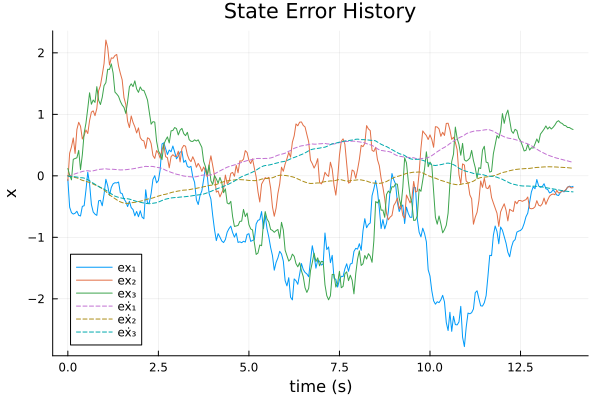

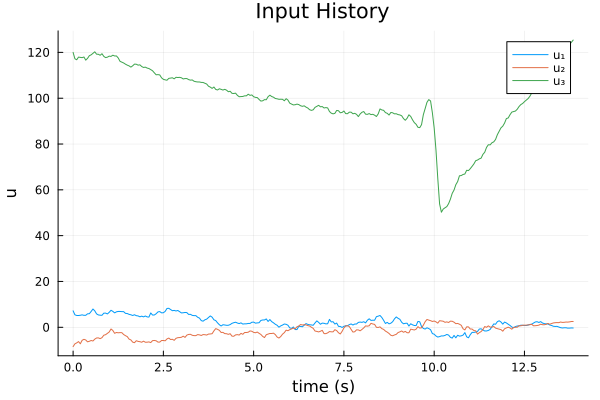

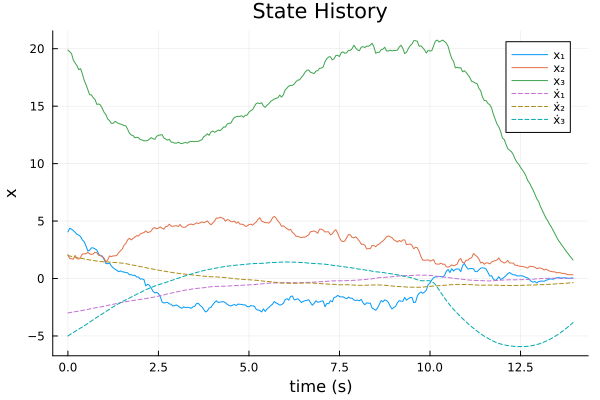

In [ ]:
Xsim_m = mat_from_vec(Xhist[1:end-Nh])
Usim_m = mat_from_vec(Uhist[1:end-Nh-1])
e_sim_m = mat_from_vec(Xref[1:end-Nh]-Xhist[1:end-Nh])
@show traj_error = maximum(norm.(e_sim_m, Inf))
display(plot(t_vec[1:end-Nh],e_sim_m',label = ["ex₁" "ex₂" "ex₃" "eẋ₁" "eẋ₂" "eẋ₃"], 
             linestyle=[:solid :solid :solid :dash :dash :dash], 
             title = "State Error History",
             xlabel = "time (s)", ylabel = "x"))
display(plot(t_vec[1:end-Nh-2],Usim_m',label = ["u₁" "u₂" "u₃"],
             title = "Input History",
             xlabel = "time (s)", ylabel = "u"))
display(plot(t_vec[1:end-Nh],Xsim_m',label = ["x₁" "x₂" "x₃" "ẋ₁" "ẋ₂" "ẋ₃"], 
             linestyle=[:solid :solid :solid :dash :dash :dash],
             title = "State History",
             xlabel = "time (s)", ylabel = "x"))